In [118]:
import numpy as np
import pandas as pd
import pprint
import matplotlib.pyplot as plt
from scipy import stats

In [11]:
df = pd.read_csv("sample_string.csv", index_col = "Index")
df

,Marital status,Application mode,University's position in preferences when applying,Course,Daytime/evening attendance,Previous qualification,Nationality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem enrolled,Total exams across all classes in 2nd sem,Curricular units 2nd sem passed,Curricular units 2nd sem grade,Curricular units 2nd sem without exams,Unemployment rate at enrollment,Inflation rate at enrollment,GDP at enrollment,Target,AI prediction
Index,,,,,,,,,,,,,,,,,,,,,
648,Single,Change in course,2,Oral Hygiene,daytime,Secondary education,Portuguese,Secondary Education—12th Year of Schooling or ...,Basic Education 3rd Cycle (9th/10th/11th Year)...,Administrative staff,...,8,10,8,13.212500,0,10.8,1.4,1.74,Graduate,Graduate
2781,Single,1st phase—general contingent,1,Basic Education,daytime,Secondary education,Portuguese,2nd cycle of the general high school course,Basic education 1st cycle (4th/5th year) or eq...,Unskilled Workers,...,6,14,1,11.000000,0,10.8,1.4,1.74,Dropout,Dropout
2883,Married,Over 23 years old,1,Social Service (evening attendance),evening,Secondary education,Portuguese,General Course of Administration and Commerce,Basic education 1st cycle (4th/5th year) or eq...,Unskilled Workers,...,6,8,6,11.500000,0,8.9,1.4,3.51,Graduate,Graduate
266,Single,2nd phase—general contingent,4,Nursing,daytime,Secondary education,Portuguese,Higher Education—master’s degree,Secondary Education—12th Year of Schooling or ...,Specialists in Intellectual and Scientific Act...,...,8,8,7,14.828571,0,12.7,3.7,-1.70,Graduate,Graduate
2537,Single,1st phase—general contingent,1,Advertising and Marketing Management,daytime,Secondary education,Portuguese,General commerce course,Basic Education 3rd Cycle (9th/10th/11th Year)...,"Skilled Workers in Industry, Construction, and...",...,6,6,6,15.833333,0,12.4,0.5,1.79,Graduate,Graduate
2791,Single,1st phase—general contingent,1,Veterinary Nursing,daytime,Secondary education,Portuguese,Supplementary Accounting and Administration,Basic Education 3rd Cycle (9th/10th/11th Year)...,Unskilled Workers,...,6,8,6,14.142857,0,11.1,0.6,2.02,Graduate,Graduate
1576,Married,Over 23 years old,2,Advertising and Marketing Management,daytime,Basic education 3rd cycle (9th/10th/11th year)...,Portuguese,General Course of Administration and Commerce,Basic education 1st cycle (4th/5th year) or eq...,Unskilled Workers,...,6,9,4,13.750000,0,12.4,0.5,1.79,Dropout,Dropout
988,Single,1st phase—general contingent,1,Social Service,daytime,Secondary education,Portuguese,Higher Education—bachelor’s degree,Higher Education—bachelor’s degree,Intermediate Level Technicians and Professions,...,6,12,2,10.000000,0,11.1,0.6,2.02,Dropout,Dropout
3232,Single,1st phase—general contingent,2,Journalism and Communication,daytime,Secondary education,Portuguese,General commerce course,Basic Education 2nd Cycle (6th/7th/8th Year) o...,Intermediate Level Technicians and Professions,...,6,6,5,12.600000,0,12.7,3.7,-1.70,Graduate,Graduate


In [13]:
df.loc[648]['Target']

'Graduate'

In [90]:
with open("0_3.csv") as file:
    lines = file.readlines()
lines

['Prolific ID,5962afc407ed5e0001cd0ff3\n',
 '3053,DROPOUT,DROPOUT,1693945092.8080535,1693945094.8562708,1693945109.0383856\n',
 '648,DROPOUT,DROPOUT,1693945150.1007197,1693945151.3617506,1693945153.2352967\n',
 '2537,GRADUATE,GRADUATE,1693945173.5729647,1693945174.9136503,1693945176.9538682\n',
 '266,GRADUATE,GRADUATE,1693945207.019705,1693945210.2217991,1693945211.556049\n',
 '3214,GRADUATE,GRADUATE,1693945227.508992,1693945228.6848972,1693945230.2725754\n',
 '988,DROPOUT,DROPOUT,1693945251.0137973,1693945252.227803,1693945254.309909\n',
 '131,GRADUATE,GRADUATE,1693945279.7582524,1693945280.8177438,1693945282.0859222\n',
 '2883,GRADUATE,GRADUATE,1693945305.1338422,1693945306.525985,1693945307.8029296\n',
 '4096,GRADUATE,GRADUATE,1693945323.6416445,1693945324.327565,1693945347.1672018\n',
 '2791,GRADUATE,GRADUATE,1693945367.31449,1693945368.5977972,1693945369.6718743\n',
 '2781,DROPOUT,DROPOUT,1693945384.7748177,1693945385.6097999,1693945386.9856157\n',
 '3920,DROPOUT,DROPOUT,169394541

In [27]:
likert_calc = {"STRONGLY AGREE":2, "AGREE":1, "NEUTRAL":0, "DISAGREE":-1, "STRONGLY DISAGREE":-2}

In [128]:
participants_results = {}
participants_tasks = {}
participants_hct = {}

for group in range(2):
    
    for p in range(39):

        p_id = str(group) + "_" + str(p)
        test_file = p_id + ".csv"
        
        with open(test_file) as file:
            lines = file.readlines()
            
        if not len(lines) == 31:
            print("- unvollstaendig - ")
            continue

        participant = {"file":test_file, "group":group, "participant_number":p, "final_accuracy":0, "ai_agreement":0, 
                       "n_na":0, "n_wt":0, "n_wmt":0, "n_ut":0, "n_ot":0}
        tasks = {}
        hct = {}

        for i, l in enumerate(lines):

            l = l.strip()
            line = l.split(",")

            if i == 0:
                participant[line[0]] = line[1]

            elif i < 16:

                student_id = int(line[0])
                correct_decision = df.loc[student_id]['Target'].upper()
                AI_decision = df.loc[student_id]['AI prediction'].upper()

                tasks[student_id] = {}

                if len(line) == 6: # user first

                    if not "priming" in participant:
                        participant["priming"] = False # meaning user gets to make decision first
                        assert participant["priming"] == participant["group"]

                    if not "user_accuracy" in participant:
                        participant["user_accuracy"] = 0

                    user_time = float(line[4]) - float(line[3])
                    final_time = float(line[5]) - float(line[4])
                    user_decision = line[1]
                    final_decision = line[2]
                    user_correct = (correct_decision == user_decision)
                    if user_correct:
                        participant["user_accuracy"] += 1

                    tasks[student_id]["user_time"] = user_time
                    tasks[student_id]["user_decision"] = user_decision
                    tasks[student_id]["user_decision_correct"] = user_correct

                    if user_decision == AI_decision:
                        participant["n_na"] += 1
                    else:
                        if AI_decision == correct_decision:
                            if final_decision == AI_decision:
                                participant["n_wt"] += 1
                            else:
                                participant["n_ut"] += 1
                        else:
                            if final_decision == AI_decision:
                                participant["n_ot"] += 1
                            else:
                                participant["n_wmt"] += 1

                else: # AI priming

                    if not "priming" in participant:
                        participant["priming"] = True # meaning user gets to make decision first
                        assert participant["priming"] == participant["group"]

                    final_time = float(line[3]) - float(line[2])
                    final_decision = line[1]

                final_decision_correct = (final_decision == correct_decision)
                if final_decision_correct:
                    participant["final_accuracy"] += 1
                    
                if final_decision == AI_decision:
                    participant["ai_agreement"] += 1

                tasks[student_id]["final_decision"] = final_decision
                tasks[student_id]["final_decision_correct"] = final_decision_correct
                tasks[student_id]["final_time"] = final_time

            elif i == 16: # AI knowledge

                participant["AI_knowledge"] = line[1:]

            elif i == 17: # user perceived accuracy

                participant["perceived_accuracy"] = int(line[1])/15

            elif i == 18: # user perceived knowledge

                assert line[0] == "know"
                participant["perceived_domain_knowledge"] = likert_calc[line[1]]

            else:

                hct[line[0]] = likert_calc[line[1]]
        
        participant["switch_ratio"] = 0
        participant["switch_not_ratio"] = 0
        if group == 0:
            participant["switch_ratio"] = (participant["n_wt"] + participant["n_ot"])/(15 - participant["n_na"])
            participant["switch_not_ratio"] = (participant["n_wmt"] + participant["n_ut"])/(15 - participant["n_na"])
        
        trust_values = list(hct.values())
        participant["total_trust"] = np.mean(trust_values)

        trust = {"fai":[], "com":[], "rel":[]}

        for key in hct:
            if "fai" in key:
                trust["fai"].append(hct[key])
            if "com" in key:
                trust["com"].append(hct[key])
            if "rel" in key:
                trust["rel"].append(hct[key])

        participant["fai"] = np.mean(trust["fai"])
        participant["com"] = np.mean(trust["com"])
        participant["rel"] = np.mean(trust["rel"])

        final_accuracy = participant["final_accuracy"]/15
        participant["final_accuracy"] = final_accuracy
        if "user_accuracy" in participant:
            user_accuracy = participant["user_accuracy"]/15
            participant["user_accuracy"] = user_accuracy
        ai_agreement = participant["ai_agreement"]
        participant["ai_agreement"] = ai_agreement/15
            
        participants_results[p_id] = participant
        participants_tasks[p_id] = tasks
        participants_hct[p_id] = hct
        
        #pprint.pprint(participant)
        #pprint.pprint(tasks)
        #pprint.pprint(hct)
        
        #print("---")


- unvollstaendig - 
- unvollstaendig - 
- unvollstaendig - 
- unvollstaendig - 
- unvollstaendig - 
- unvollstaendig - 
- unvollstaendig - 
- unvollstaendig - 
- unvollstaendig - 


In [129]:
results = pd.DataFrame.from_dict(participants_results, orient='index')
results

,file,group,participant_number,final_accuracy,ai_agreement,n_na,n_wt,n_wmt,n_ut,n_ot,...,user_accuracy,AI_knowledge,perceived_accuracy,perceived_domain_knowledge,switch_ratio,switch_not_ratio,total_trust,fai,com,rel
0_0,0_0.csv,0,0,0.466667,0.600000,7,0,1,5,2,...,0.600000,"[NO, ]",0.666667,1,0.250000,0.750000,0.250000,-0.2,0.75,0.333333
0_1,0_1.csv,0,1,0.800000,0.800000,9,2,2,1,1,...,0.733333,"[NO, ]",0.733333,0,0.500000,0.500000,-0.250000,-1.0,0.25,0.333333
0_3,0_3.csv,0,3,0.866667,0.733333,10,1,3,1,0,...,0.800000,"[YES, Through ChatGPT, as well as discussions...",0.866667,0,0.200000,0.800000,-0.666667,-1.0,-0.50,-0.333333
0_4,0_4.csv,0,4,1.000000,0.733333,10,1,4,0,0,...,0.933333,"[YES, I am in a master of artificial inteligen...",0.800000,1,0.200000,0.800000,0.000000,-0.4,0.25,0.333333
0_5,0_5.csv,0,5,0.800000,0.800000,8,3,2,1,1,...,0.666667,"[YES, I come into contact with ai in chat bots]",0.600000,2,0.571429,0.428571,0.583333,0.8,0.50,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1_34,1_34.csv,1,34,0.800000,0.666667,0,0,0,0,0,...,NaN,"[YES, I was playing ChatGPT already and other ...",0.266667,2,0.000000,0.000000,-0.750000,-1.0,-0.50,-0.666667
1_35,1_35.csv,1,35,0.600000,0.600000,0,0,0,0,0,...,NaN,"[YES, I often use ChatGPT to know more about h...",0.800000,2,0.000000,0.000000,1.416667,1.2,1.50,1.666667
1_36,1_36.csv,1,36,0.733333,1.000000,0,0,0,0,0,...,NaN,"[YES, I use it at my day job]",0.866667,2,0.000000,0.000000,0.000000,-0.6,0.50,0.333333
1_37,1_37.csv,1,37,0.733333,0.733333,0,0,0,0,0,...,NaN,"[NO, ]",0.600000,-1,0.000000,0.000000,0.583333,-0.4,1.25,1.333333


In [130]:
results_0 = results[results["group"] == 0]
results_1 = results[results["group"] == 1]

In [131]:
def compare_groups(column):
    
    print(column.upper())
    
    print(stats.ttest_ind(results_0[column], results_1[column]))

    fig, ax = plt.subplots()
    VP = ax.boxplot([results_0[column], results_1[column]], labels = ["no priming", "priming"])
    plt.show()

FINAL_ACCURACY
Ttest_indResult(statistic=-1.192258608570181, pvalue=0.23736553925140416)


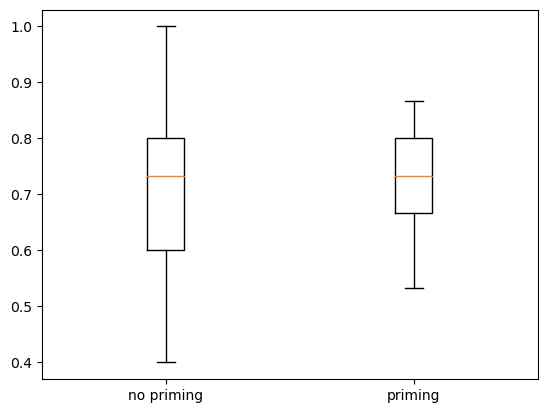

In [132]:
compare_groups("final_accuracy")

PERCEIVED_ACCURACY
Ttest_indResult(statistic=-0.026729437079977634, pvalue=0.9787549895629108)


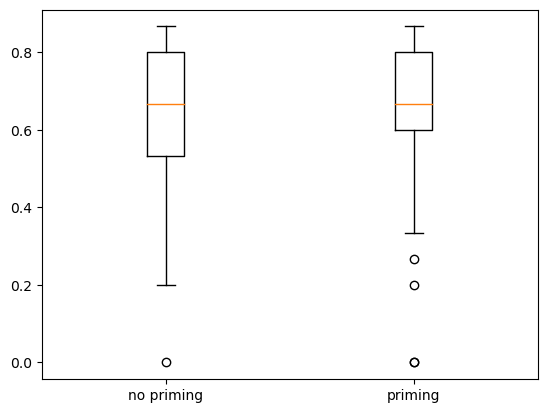

In [133]:
compare_groups("perceived_accuracy")

PERCEIVED_DOMAIN_KNOWLEDGE
Ttest_indResult(statistic=1.318105336039253, pvalue=0.19195716884851738)


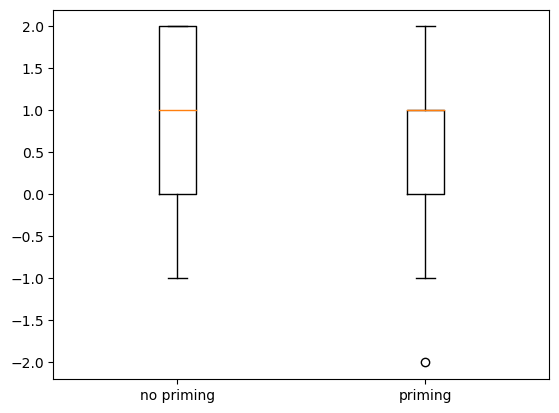

In [134]:
compare_groups("perceived_domain_knowledge")

TOTAL_TRUST
Ttest_indResult(statistic=-0.6848251896036786, pvalue=0.49581658310965615)


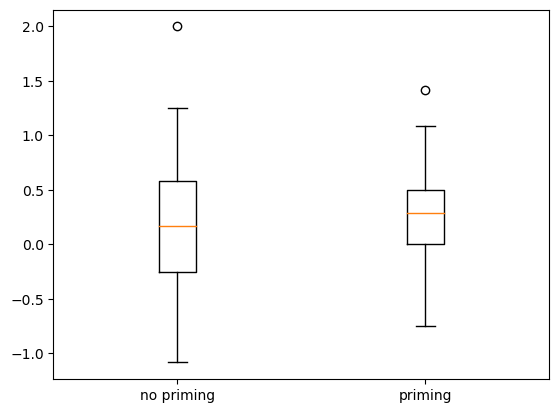

In [135]:
compare_groups("total_trust")

AI_AGREEMENT
Ttest_indResult(statistic=0.04319883470458696, pvalue=0.9656715196630632)


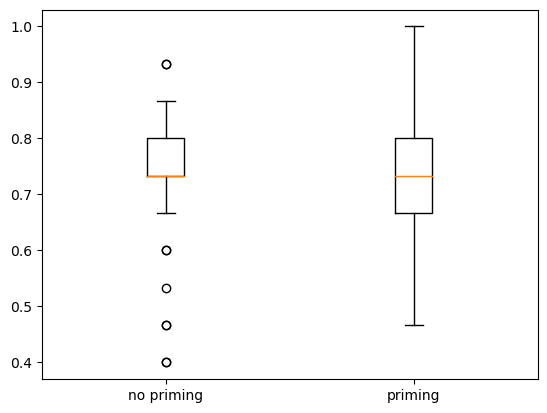

In [136]:
compare_groups("ai_agreement")

REL
Ttest_indResult(statistic=-0.4279310322536128, pvalue=0.6700737541741393)


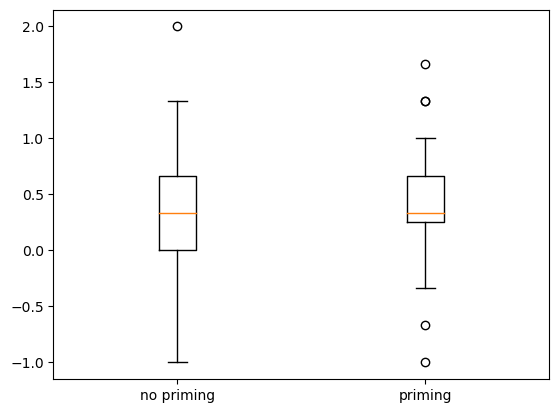

In [126]:
compare_groups("rel")

In [109]:
def scatter(df, column_x, column_y):

    fig, ax = plt.subplots()
    SC = ax.scatter(df[column_x], df[column_y])
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)
    plt.show()

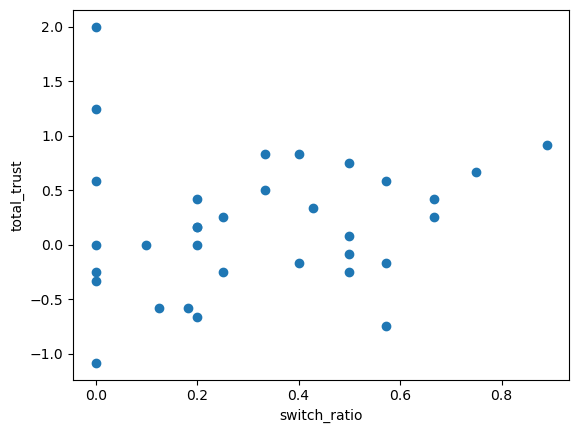

In [111]:
scatter(results_0, "switch_ratio", "total_trust")

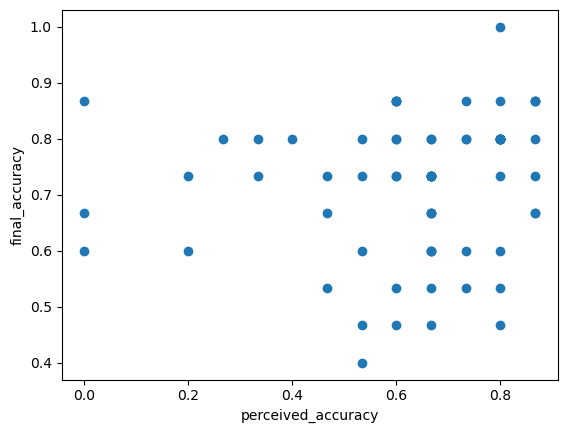

In [113]:
scatter(results, "perceived_accuracy", "final_accuracy")

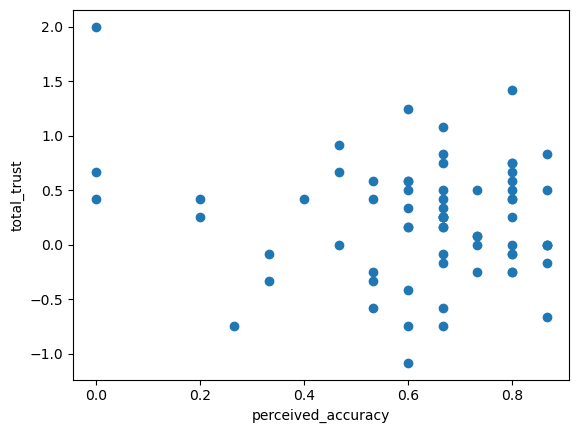

In [114]:
scatter(results, "perceived_accuracy", "total_trust")

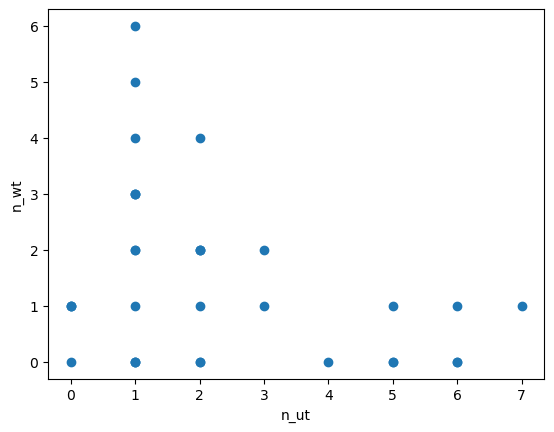

In [117]:
scatter(results_0, "n_ut", "n_wt")